# **Cameroon Air Quality Prediction**

## **Model Performance and Improvements**

At the conclusion of the **Cameroon Air Quality Prediction** competition, the model achieved a ranking of **5th place** on the leaderboard. Following the competition, **substantial improvements** were made to the model, which was based on **AutoGluon**'s TabularPredictor. Key improvements included:
- **Hyperparameter optimization** through AutoGluon’s automated search for the best configurations.
- **Enhanced feature engineering** which improved the model's predictive capabilities.
- **Refinement of model selection** and tuning, leveraging AutoGluon’s `presets='best_quality'` for optimal results.

These adjustments led to a **significant improvement** in model performance, resulting in surpassing the top score on the leaderboard, marking a successful outcome through **continuous optimization** with AutoGluon.

The final model’s performance demonstrates the impact of iterative enhancements and the potential for model improvements even beyond the competition period.

The competition page for the **Cameroon Air Quality Prediction** challenge and the notebook for this project can be found on [Kaggle](https://www.kaggle.com/code/enisezengin/autogluon-privatescore-2-97008).




# **`1.` Required Libraries**

In [ ]:
!python -m pip install --upgrade pip --quiet
!python -m pip install autogluon --quiet
!pip install --upgrade scikit-learn --quiet

from autogluon.tabular import TabularPredictor

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime

from autogluon.tabular import TabularPredictor

# **`2.` Load Data**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/Cameroon Air Quality Prediction/"
zip_path = os.path.join(path, "cameroon-air-quality-prediction.zip")
dir = os.path.join('..', 'air_quality')

from zipfile import ZipFile
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dir)

In [ ]:
train_raw = pd.read_csv(os.path.join(dir, 'train.csv'))
test_raw = pd.read_csv(os.path.join(dir, 'test.csv'))
ss_df = pd.read_csv(os.path.join(dir, 'sample_submission.csv'))

train_raw.shape, test_raw.shape, ss_df.shape

((4120, 33), (1030, 32), (1030, 2))

# **`3.` Configuration**

In [ ]:
pd.set_option('display.max_columns', train_raw.shape[1])
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

seed=42
target = 'pm2_5'
y = train_raw[target]

# **`4.` Data Exploration and Preparation**

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           4120 non-null   int64  
 1   weather_code                 4120 non-null   float64
 2   temperature_2m_max           4120 non-null   float64
 3   temperature_2m_min           4120 non-null   float64
 4   temperature_2m_mean          4120 non-null   float64
 5   apparent_temperature_max     4120 non-null   float64
 6   apparent_temperature_min     4120 non-null   float64
 7   apparent_temperature_mean    4120 non-null   float64
 8   sunrise                      4120 non-null   int64  
 9   sunset                       4120 non-null   int64  
 10  daylight_duration            4120 non-null   float64
 11  sunshine_duration            4120 non-null   float64
 12  precipitation_sum            4120 non-null   float64
 13  rain_sum          

In [ ]:
train_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4120.000,2059.500,1189.486,0.000,1029.750,2059.500,3089.250,4119.000
weather_code,4120.000,41.405,25.703,0.000,3.000,51.000,63.000,65.000
temperature_2m_max,4120.000,28.818,3.977,18.023,26.331,28.529,30.753,42.312
temperature_2m_min,4120.000,19.627,3.153,11.031,17.081,19.767,21.541,29.913
temperature_2m_mean,4120.000,23.438,3.326,16.890,20.968,23.068,25.358,35.300
apparent_temperature_max,4120.000,31.627,4.202,19.531,28.632,31.607,34.541,44.293
apparent_temperature_min,4120.000,21.308,4.681,8.124,17.767,21.387,24.302,32.163
apparent_temperature_mean,4120.000,25.506,4.067,16.245,22.129,25.486,28.271,37.267
sunrise,4120.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
sunset,4120.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
train_raw.isna().sum().sum(), test_raw.isna().sum().sum(), train_raw.duplicated().sum(), test_raw.duplicated().sum()

(0, 0, 0, 0)

In [ ]:
train_raw[target].min(), train_raw[target].max()

(0.5750000000000001, 172.82916666666665)

The features 'sunrise', 'sunset', and 'snowfall_sum' only contain a single unique value (0), which provides no variability or useful information for the model. Therefore, these features are dropped from the dataset.

In [ ]:
test_raw[target] = -1

drop_cols = ['sunrise', 'sunset', 'snowfall_sum']
train_df = train_raw.drop(drop_cols, axis=1)
test_df = test_raw.drop(drop_cols, axis=1)

print(train_df.shape)

data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
data['source'] = np.where(data[target] == -1, 'test', 'train')

(4120, 30)


The unique weather codes were examined to identify any unexpected or anomalous codes:

In [ ]:
data['weather_code'].unique()

array([ 1., 65.,  3., 51., 63., 53., 61.,  2.,  0., 55.])

In [ ]:
# Check temperature relationship
data[
    (data['temperature_2m_max'] < data['temperature_2m_min']) |
    (data['temperature_2m_max'] < data['temperature_2m_mean'])
]

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,latitude,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky,source


In [ ]:
# Geographical consistency by city
group_check = data.groupby(['city', 'latitude', 'longitude', 'source']).size()
group_check[group_check > 1]

city        latitude  longitude  source
Bafoussam   5.474     10.418     test       87
                                 train     428
Bamenda     5.953     10.158     test      110
                                 train     405
Bertoua     4.583     13.683     test      103
                                 train     412
Buea        4.153     9.241      test      127
                                 train     388
Douala      4.048     9.704      test       86
                                 train     429
Ebolowa     2.900     11.150     test       85
                                 train     430
Garoua      9.300     13.400     test      108
                                 train     407
Maroua      10.591    14.316     test       99
                                 train     416
Ngaoundéré  7.317     13.583     test      121
                                 train     394
Yaoundé     3.867     11.517     test      104
                                 train     411
dtype: int64

In [ ]:
# Daylight vs. Sunshine Duration
data[data['sunshine_duration'] > data['daylight_duration']]

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,latitude,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky,source


A breakdown was performed to see how many unique weather codes were recorded per city and data source.

In [ ]:
# weather_code by sity and source
data[['city', 'weather_code', 'source']].drop_duplicates().groupby(['source', 'city'], as_index=False)['weather_code']. \
    count().sort_values('weather_code', ascending=False).reset_index(drop=True)

,source,city,weather_code
0,test,Bafoussam,10
1,test,Bamenda,10
2,test,Garoua,10
3,test,Maroua,10
4,train,Garoua,10
5,train,Maroua,10
6,train,Bafoussam,10
7,test,Ngaoundéré,10
8,train,Bamenda,10
9,train,Bertoua,10


In [ ]:
# Check precipitation
data[
    (data['weather_code'] == 65.) & (data['precipitation_sum'] == 0.0)
]

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,latitude,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky,source


In [ ]:
train_raw[(train_raw['weather_code']==1.) & (train_raw['precipitation_sum']==0.0)][['weather_code', 'precipitation_sum', 'precipitation_hours']]

,weather_code,precipitation_sum,precipitation_hours
0,1.000,0.000,0.000
1,1.000,0.000,0.000
3,1.000,0.000,0.000
10,1.000,0.000,0.000
21,1.000,0.000,0.000
...,...,...,...
4065,1.000,0.000,0.000
4090,1.000,0.000,0.000
4105,1.000,0.000,0.000
4113,1.000,0.000,0.000


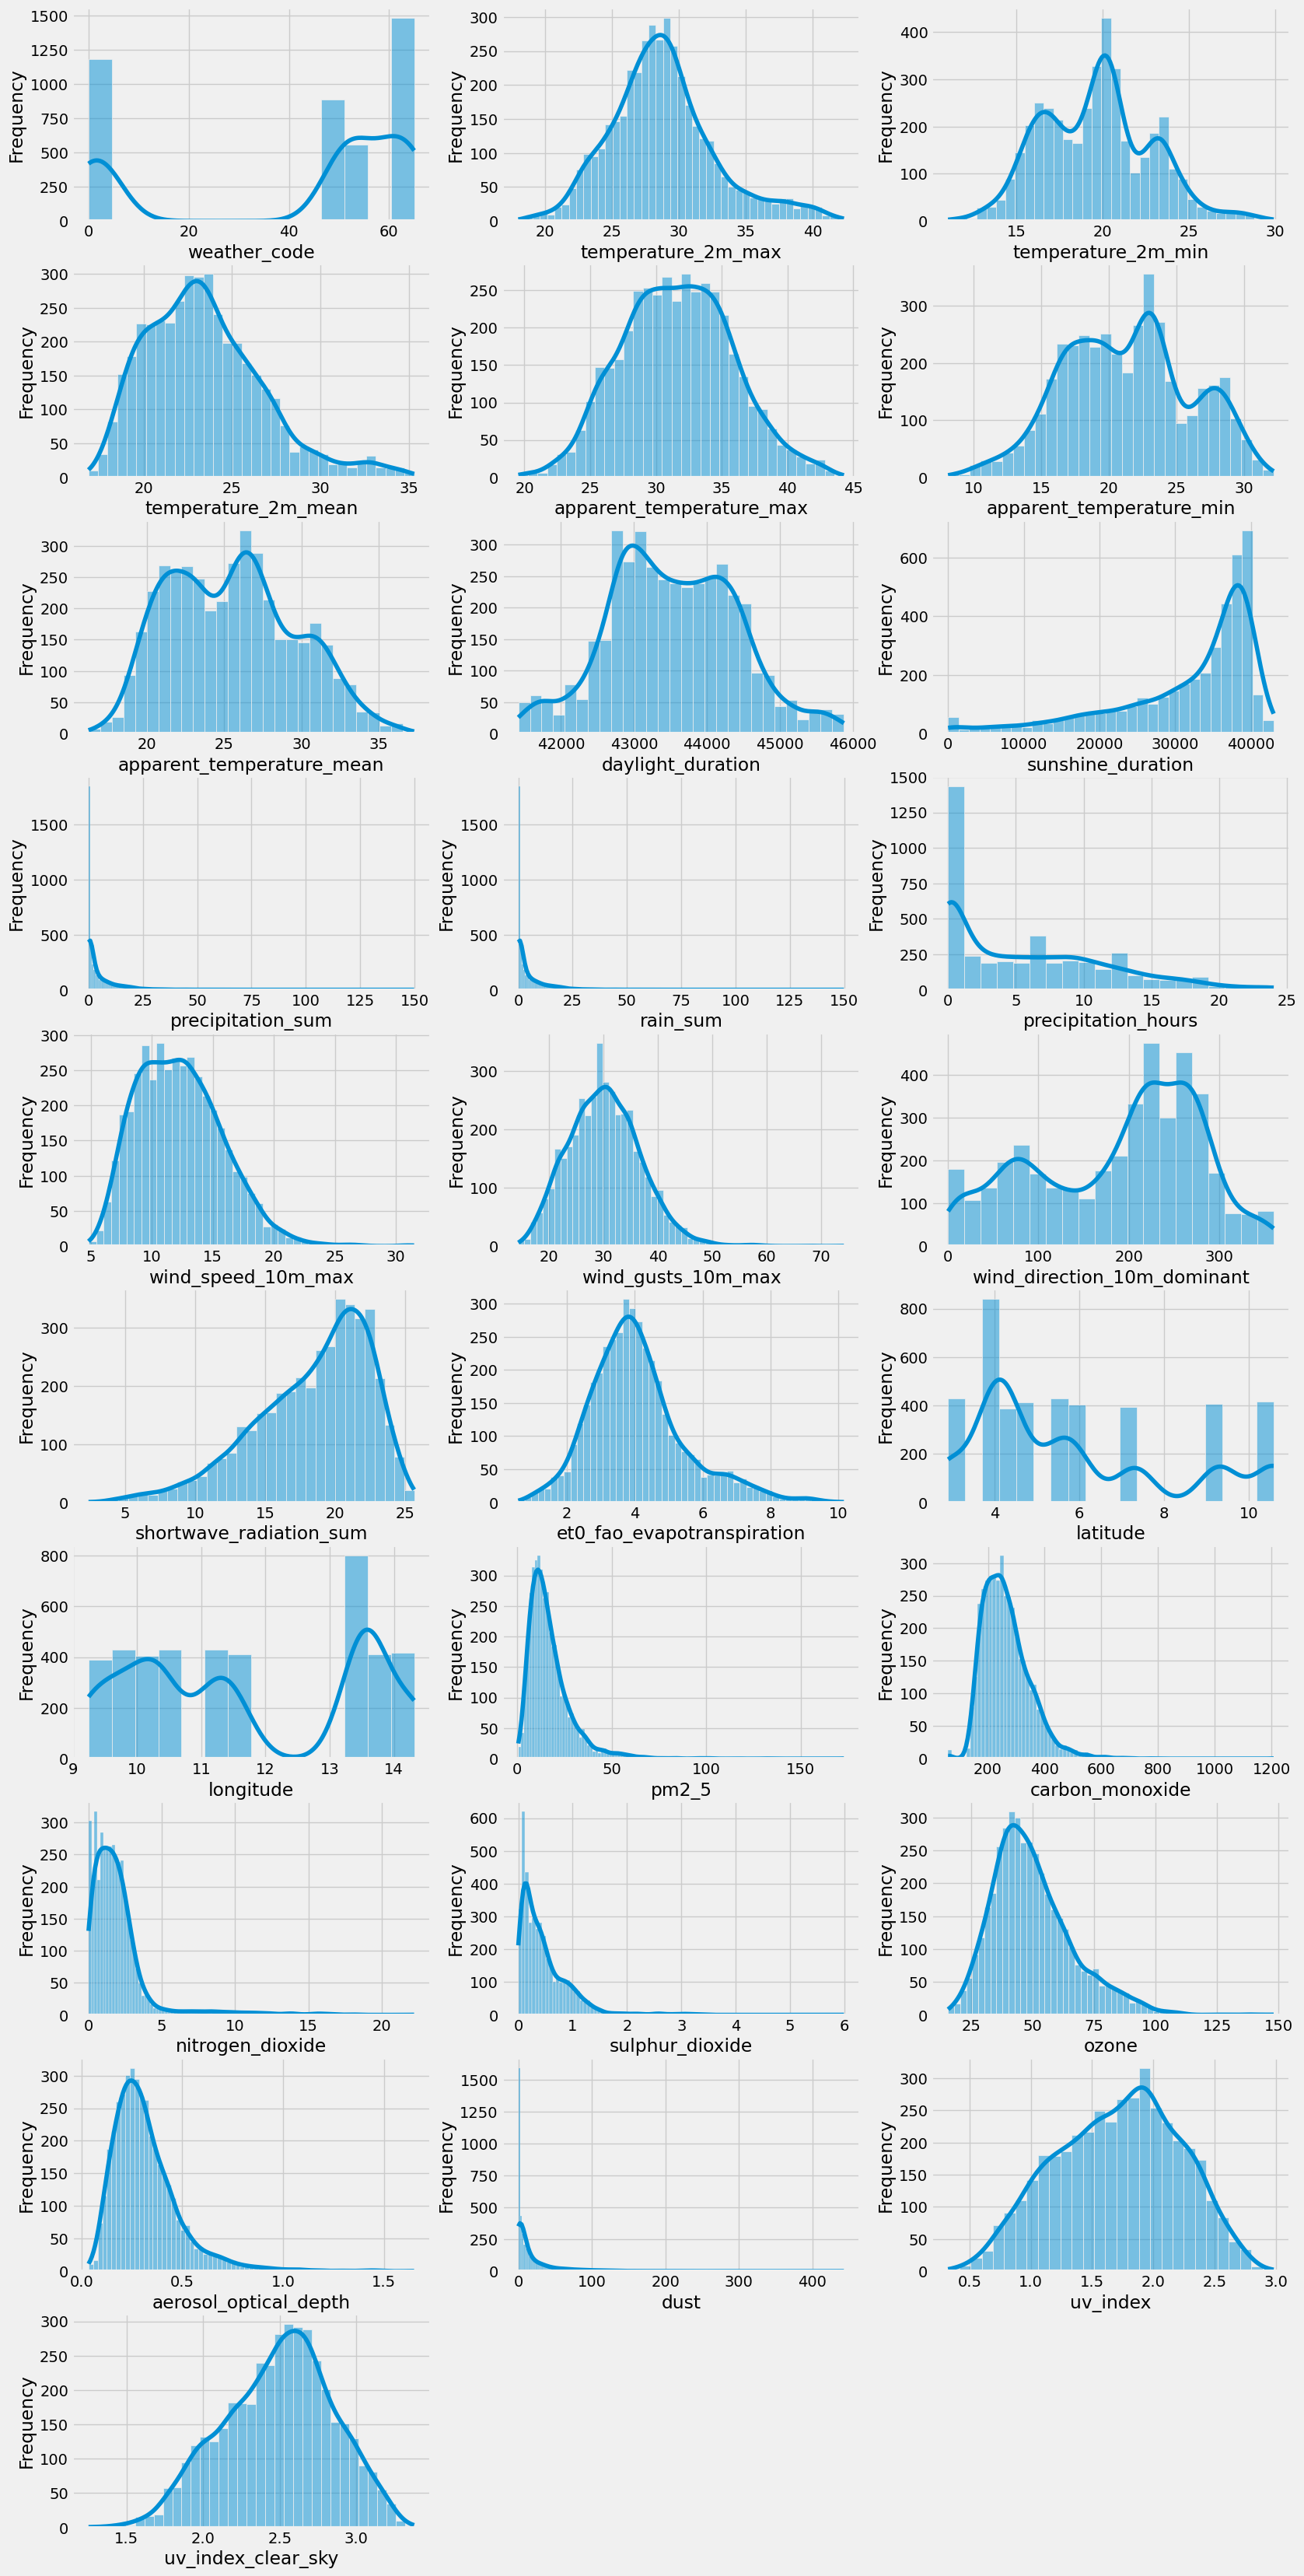

In [ ]:
def plot_features(df, features, figsize_org=(3, 4),  **kwargs):
    n_feats = len(features)

    num_cols = n_feats if n_feats < 4 else 2 if n_feats == 4 else 3
    num_rows = int(np.ceil(n_feats / num_cols))
    figsize = (figsize_org[0] * num_cols * 2, figsize_org[1] * num_rows)

    plt.figure(figsize=figsize)
    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(df[feature], kde=True, **kwargs)
        plt.ylabel('Frequency')

num_features = train_df.select_dtypes(exclude=['object', 'category']).columns
plot_features(train_df, num_features[1:])

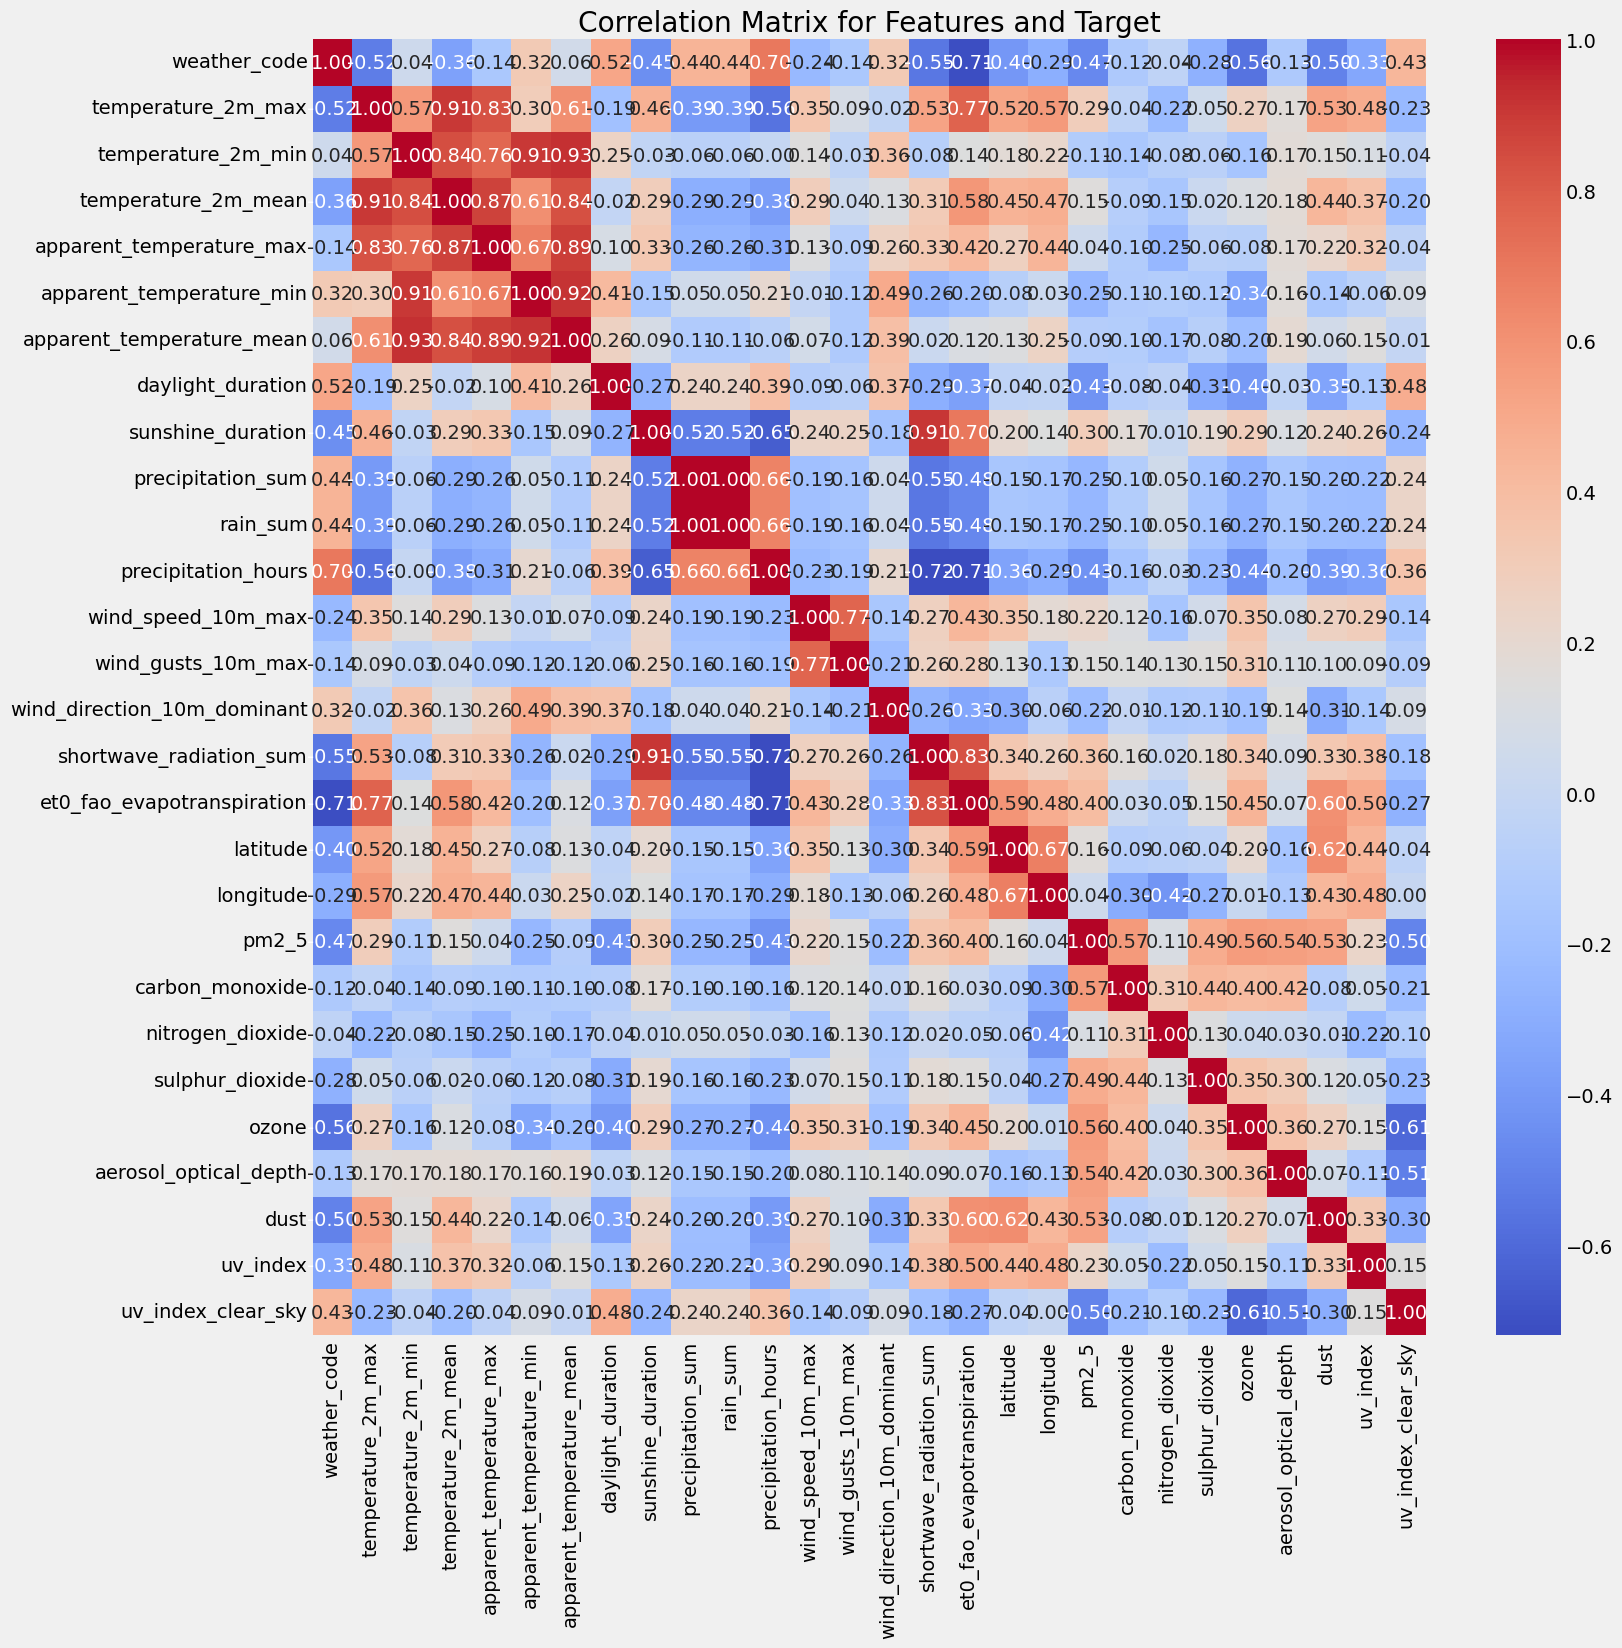

In [ ]:
corr_matrix = train_df[num_features[1:]].corr()

# Visualize correlation
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Features and Target')
plt.show()

To identify features with low predictive power for the target variable (pm2_5), a correlation analysis was conducted. Features with a correlation value below 0.1 were deemed to have weak relationships with the target and were flagged as low-correlation features.

In [ ]:
target_corr = corr_matrix[target].abs().sort_values()
low_corr_features = target_corr[target_corr < 0.1].index.tolist()
print(f"Low Correlation Features with Target Variable: {low_corr_features}\n")

Low Correlation Features with Target Variable: ['apparent_temperature_max', 'longitude', 'apparent_temperature_mean']



# **`5.` Feature Engineering**

In the analysis, Bafoussam was found to have the highest average pm2_5 levels among the cities. To capture potential spatial influences on air quality, a **distance_to_target** feature was created to measure the distance of each city to Bafoussam.

In [ ]:
train_raw.groupby('city')['pm2_5'].mean().sort_values(ascending=False)

city
Bafoussam    21.769
Garoua       21.009
Bamenda      20.147
Maroua       18.975
Bertoua      17.206
Douala       16.375
Yaoundé      16.215
Ngaoundéré   14.739
Buea         13.955
Ebolowa      10.883
Name: pm2_5, dtype: float64

Haversine Function: The haversine function calculates the distance between two geographical coordinates (latitude and longitude) using the Haversine formula.

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # The Earth's radius
    R = 6371.0

    # The differences in latitude and longitude are converted to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Perform Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # The distance
    distance = R * c

    return distance

def generate_features(df):
    df = df.copy()
    # The target city
    target_city = 'Bafoussam'
    target_lat = df.loc[df['city'] == target_city, 'latitude'].values[0]
    target_lon = df.loc[df['city'] == target_city, 'longitude'].values[0]

    # Calculate distance
    df['distance_to_target'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], target_lat, target_lon), axis=1)

    # The city column is converted to a categorical type for more efficient processing
    df['city'] = df['city'].astype('category')

    drop_cols = low_corr_features + ['id', 'latitude']
    df = df.drop(drop_cols, axis=1)
    return df

train, test = generate_features(train_df), generate_features(test_df)
test.drop(target, axis=1, inplace=True)

print(train.shape, test.shape)

(4120, 26) (1030, 25)


# **`6.` Modelling**

In [ ]:
t1 = datetime.now()
predictor = TabularPredictor(label=target, problem_type='regression').fit(
    train_data=train,
    num_bag_folds=5,
    presets='best_quality',
    time_limit=1000,
)
t2 = datetime.now()

print(f"Execution time: {t1-t2}")

No path specified. Models will be saved in: "AutogluonModels/ag-20241112_231005"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       30.01 GB / 31.36 GB (95.7%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets o

(_ray_fit pid=399) [1000]	valid_set's rmse: 4.66498
(_ray_fit pid=398) [4000]	valid_set's rmse: 3.20489 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=398) [8000]	valid_set's rmse: 3.19914 [repeated 7x across cluster]


(_dystack pid=213) 	-3.6339	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	25.55s	 = Training   runtime
(_dystack pid=213) 	2.1s	 = Validation runtime
(_dystack pid=213) Fitting model: LightGBM_BAG_L1 ... Training model for up to 130.83s of the 212.4s of remaining time.
(_dystack pid=213) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(_ray_fit pid=559) [1000]	valid_set's rmse: 3.09416 [repeated 3x across cluster]
(_ray_fit pid=557) [3000]	valid_set's rmse: 3.3376 [repeated 6x across cluster]
(_ray_fit pid=557) [6000]	valid_set's rmse: 3.33589 [repeated 3x across cluster]


(_dystack pid=213) 	-3.7182	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	22.21s	 = Training   runtime
(_dystack pid=213) 	1.25s	 = Validation runtime
(_dystack pid=213) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 103.87s of the 185.44s of remaining time.
(_dystack pid=213) 	-3.8967	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	8.23s	 = Training   runtime
(_dystack pid=213) 	0.3s	 = Validation runtime
(_dystack pid=213) Fitting model: CatBoost_BAG_L1 ... Training model for up to 95.15s of the 176.72s of remaining time.
(_dystack pid=213) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=715) 	Ran out of time, early stopping on iteration 2388.
(_dystack pid=213) 	-3.4557	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	78.35s	 = Training   runtime
(_dystack pid=213) 	0.05s	 = Validation runtime
(_dystack

(_ray_fit pid=1229) [1000]	valid_set's rmse: 4.65403 [repeated 2x across cluster]


(_dystack pid=213) 	-3.5572	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	12.06s	 = Training   runtime
(_dystack pid=213) 	0.2s	 = Validation runtime
(_dystack pid=213) Fitting model: LightGBM_BAG_L2 ... Training model for up to 55.91s of the 55.86s of remaining time.
(_dystack pid=213) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(_ray_fit pid=1378) [1000]	valid_set's rmse: 4.82219
(_ray_fit pid=1378) [2000]	valid_set's rmse: 4.79904
(_ray_fit pid=1378) [3000]	valid_set's rmse: 4.79065
(_ray_fit pid=1378) [4000]	valid_set's rmse: 4.78568
(_ray_fit pid=1378) [5000]	valid_set's rmse: 4.78471
(_ray_fit pid=1378) [6000]	valid_set's rmse: 4.7844
(_ray_fit pid=1378) [7000]	valid_set's rmse: 4.7843
(_ray_fit pid=1378) [8000]	valid_set's rmse: 4.78425


(_ray_fit pid=1378) 	Ran out of time, early stopping on iteration 8613. Best iteration is:
(_ray_fit pid=1378) 	[8613]	valid_set's rmse: 4.78424
(_dystack pid=213) 	-3.5642	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	33.34s	 = Training   runtime
(_dystack pid=213) 	1.08s	 = Validation runtime
(_dystack pid=213) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 16.83s of the 16.78s of remaining time.
(_dystack pid=213) 	-3.3757	 = Validation score   (-root_mean_squared_error)
(_dystack pid=213) 	11.05s	 = Training   runtime
(_dystack pid=213) 	0.31s	 = Validation runtime
(_dystack pid=213) Fitting model: CatBoost_BAG_L2 ... Training model for up to 5.25s of the 5.2s of remaining time.
(_dystack pid=213) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_ray_fit pid=1417) 	Ran out of time, early stopping on iteration 81.
(_dystack pid=213) 	-3.5388	 = Validation s

Execution time: -1 day, 23:43:11.761880


# **`7.` Evaluation and Results**

The **WeightedEnsemble_L3** model provided the best result. It confirms that combining multiple models usually leads to better performance than relying on individual models.

In [ ]:
leaderboard = predictor.leaderboard(silent=False)

                        model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3     -3.125  root_mean_squared_error          7.259   542.659                   0.001              0.057            3       True         26
1         WeightedEnsemble_L2     -3.159  root_mean_squared_error          4.763   412.246                   0.001              0.032            2       True         13
2        ExtraTreesMSE_BAG_L2     -3.224  root_mean_squared_error          6.558   460.747                   0.345              3.241            2       True         18
3      NeuralNetFastAI_BAG_L2     -3.255  root_mean_squared_error          6.371   478.820                   0.158             21.314            2       True         19
4      RandomForestMSE_BAG_L2     -3.256  root_mean_squared_error          6.569   472.590                   0.357             15.084            2       Tr

The feature importance results indicate that 'dust' is the most influential feature for the target variable, showing a high importance score of 7.052, followed by 'aerosol_optical_depth' and 'carbon_monoxide' with scores of 4.638 and 4.311, respectively. These top features suggest that particulate matter and atmospheric components play a significant role in determining air quality.

In [ ]:
predictor.feature_importance(train)

These features in provided data are not utilized by the predictor and will be ignored: ['rain_sum']
Computing feature importance via permutation shuffling for 24 features using 4120 rows with 5 shuffle sets...
	1918.97s	= Expected runtime (383.79s per shuffle set)
	1049.43s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
dust,7.085,0.129,0.000,5,7.350,6.820
carbon_monoxide,4.287,0.072,0.000,5,4.434,4.140
aerosol_optical_depth,4.243,0.060,0.000,5,4.365,4.120
sulphur_dioxide,1.746,0.111,0.000,5,1.974,1.518
daylight_duration,1.499,0.072,0.000,5,1.646,1.351
distance_to_target,0.804,0.026,0.000,5,0.856,0.751
uv_index_clear_sky,0.768,0.024,0.000,5,0.818,0.717
city,0.757,0.028,0.000,5,0.814,0.701
ozone,0.686,0.035,0.000,5,0.759,0.614
nitrogen_dioxide,0.669,0.010,0.000,5,0.689,0.648


# **`8.` Submission**

In [ ]:
top_models = list(leaderboard['model'].head(1))

for model in top_models:
    predictor.refit_full(model=model)

predictions = predictor.predict(test)

Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `predictor.fit` call.
	To learn more, refer to the `.refit_full` method docstring which explains how "_FULL" models differ from normal models.
Fitting 1 L1 models ...
Fitting model: LightGBMXT_BAG_L1_FULL ...
	4.7s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetFastAI_BAG_L1_FULL ...
	Stopping at the best epoch learned earlier - 27.
	4.5s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBMLarge_BAG_L1_FULL ...
	3.67s	 = Training   runtime
Fitting model: KNeighborsUnif_BAG_L1_FULL | Skipping fit via cloning parent ...
	0.22s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1_FULL | Skipping fit via cloning parent ...
	0.01s	 = Training   ru

In [ ]:
ss_df[target] = predictions
ss_df.to_csv('submission.csv', index=False)

In [ ]:
ss_df[target]

0      11.406
1      12.726
2      12.897
3      14.537
4      15.655
        ...  
1025   22.840
1026   26.934
1027   28.207
1028   29.437
1029   31.719
Name: pm2_5, Length: 1030, dtype: float32

<Axes: >

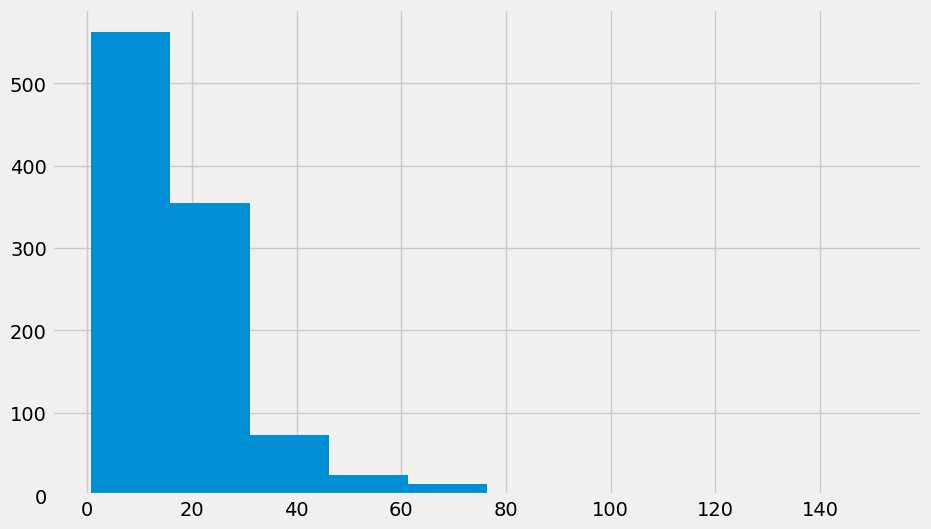

In [ ]:
ss_df[target].hist()

# **`9.` References**

https://www.sciencedirect.com/science/article/pii/S259016212400011X#abs0015

https://www.sciencedirect.com/science/article/pii/S2666765723000133

https://www.nature.com/articles/s41598-023-49717-7